# **Análisis de Componentes Principales y Análisis Cluster**
## **Índice Multidimensional de Calidad de Vida**

Vamos a llevar a cabo un análisis del **Índice Multidimensional de Calidad de Vida (IMCV)** con los datos que nos proporciona el INE. Este índice, incluye las siguientes nueve dimensiones: 


*   Dim 1: Condiciones materiales de vida
*   Dim 2: Trabajo  
*   Dim 3: Salud
*   Dim 4: Educación
*   Dim 5: Ocio y relaciones sociales
*   Dim 6: Seguridad física y personal
*   Dim 7: Gobernanza y derechos básicos
*   Dim 8: Entorno y medioambiente
*   Dim 9: Experiencia general de la vida

En concreto, tratamos de averiguar **qué comunidades autónomas se parecen más entre sí en relación a sus indicadores de calidad de vida**. Como podemos ver en la siguiente [infografía](https://public.tableau.com/app/profile/instituto.nacional.de.estad.stica/viz/IMCV_ccaaES/Dashboard2) no resulta sencillo agrupar nuestros datos cuando trabajamos con tantas variables.  

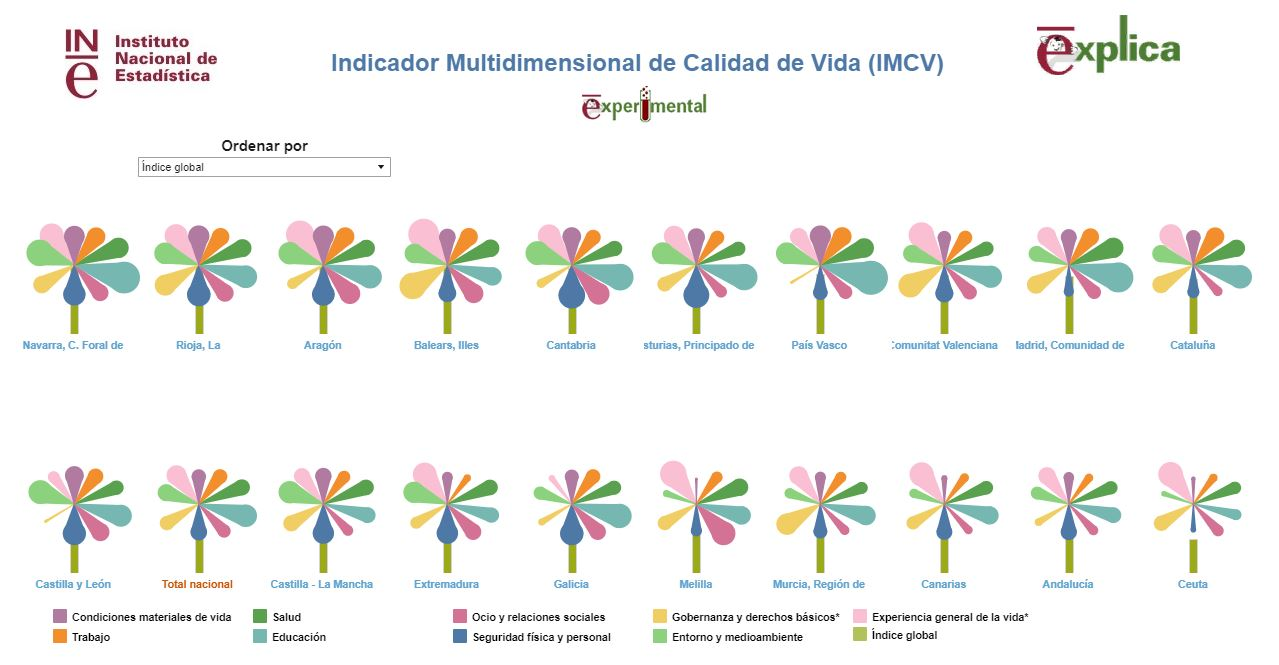

Una forma de hacer toda esta información más manejable es a través de un análisis de componentes principales, el cual nos permite reducir un número $p$ de variables correlacionadas entre sí a otro número igual de componentes no correlacionados. 

Esta técnica de análisis tiene muchas aplicaciones y en esta ocasión la utilizaremos para poder simplificar la tarea de clasificación territorios españoles en base a sus características de calidad vida. El objetivo es reducir el número de variables con las que trabajar sufriendo la menor pérdida posible de información. 
La agrupación de comunidades autónomas en grupos que compartan unas características similares la realizaremos mediante una técnica de análisis de conglomerados denominada K-medias. El objetivo es agrupar nuestras 17 comunidades y dos ciudades autónomas en un puñado de grupos homogéneos. 


In [ ]:
# Para la correcta ejecución es necesario tener instalado una serie de paquetes. 
# Si no están instalados, elimine las comillas y ejecute la celda de código.

# actualizar el SO e instalar el codec de imagenes
%%capture
!apt-get update
!apt install imagemagick

"""
# actualizar un módulo que puede dar problemas
!pip install openpyxl --upgrade --pre
"""

# instalar modulo de mapas
!pip install geopandas
# Configuración correcta de geopandas
!SHAPE_RESTORE_SHX=YES

###**Carga de librerias y datos**

In [ ]:
# Librerías para la preparación de datos
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Librerías para el Modelado
from sklearn.decomposition import PCA 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Librerías para la Visualización 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Animación de gráficos
from IPython.display import Image
from matplotlib import animation

# Trabajo con mapas
import geopandas as gpd

Cargamos el dataset que vamos a utilizar desde nuestro repositorio de **GitHub** (https://github.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE). 

In [ ]:
file = r'https://github.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE/blob/master/Datasets/IMCV_cluster.xlsx?raw=true'
datos = pd.read_excel(file, sheet_name='Datos').set_index('CCAA')
datos.head(3)

dim 1       dim 2       dim 3       dim 4       dim 5  \
CCAA                                                                         
Total nacional  100.086473  100.173269  101.341472  106.273999   99.135815   
Andalucía        97.145604   95.438031   99.164424  101.020629   96.532310   
Aragón          105.171004  103.254526  102.087682  106.871720  104.905681   

                     dim 6       dim 7       dim 8       dim 9  indice total  
CCAA                                                                          
Total nacional  101.817536  100.000000  102.117009  104.404218    101.705532  
Andalucía       101.507719   94.866659   98.877814  102.366706     98.546655  
Aragón          106.451203   97.364890  106.265277  110.513308    104.765032

Buscamos la relación entre las dimensiones y las CCAA, por lo que no escogemos ni el índice total ni el total nacional. 

In [ ]:
# No interesa ni el índice total ni el total nacional
datos = datos.iloc[1:, :9]
datos

dim 1       dim 2       dim 3       dim 4  \
CCAA                                                                         
Andalucía                    97.145604   95.438031   99.164424  101.020629   
Aragón                      105.171004  103.254526  102.087682  106.871720   
Principado de Asturias      102.217161   99.673858   99.740708  109.269506   
Illes Balears               101.819236  102.580569  102.452632  103.121771   
Canarias                     93.724567   95.792257   99.446192  103.004270   
Cantabria                   103.384392  100.617737  100.759135  109.478396   
Castilla y León             103.488110  100.852309   99.956201  105.910102   
Castilla-La Mancha          101.618109   98.494514  101.043119  101.101622   
Cataluña/Catalunya          100.282129  103.164379  102.200725  107.008120   
Comunitat Valenciana         99.422250   99.649904   99.897972  106.090282   
Extremadura                  97.373528   94.601312  101.016169  100.661990   
Galicia                      99.774493  100.167104   99.743721  107.763791   
Comunidad de Madrid         101.303909  102.158679  104.650250  112.036578   
Región de Murcia             97.523273   97.378712   98.196416  103.989030   
Comunidad Foral de Navarra  104.905800  103.190633  104.615765  113.380004   
País Vasco/Euskadi          105.289573  103.424874  103.953344  115.145822   
La Rioja                    105.307928  102.530414  102.784099  106.377724   
Ciudad Autónoma de Ceuta     92.317753   95.263833   98.524804   97.352083   
Ciudad Autónoma de Melilla   91.123714   97.667152  102.371274  103.202559   

                                 dim 5       dim 6       dim 7       dim 8  \
CCAA                                                                         
Andalucía                    96.532310  101.507719   94.866659   98.877814   
Aragón                      104.905681  106.451203   97.364890  106.265277   
Principado de Asturias       97.969853  108.838866  100.230101  105.887355   
Illes Balears               103.934138  102.634735  109.353275  104.083441   
Canarias                     95.453267  101.237226   99.068685   96.160594   
Cantabria                   105.592440  109.476732   96.026796  107.400258   
Castilla y León             102.902220  106.844642   91.223727  107.337149   
Castilla-La Mancha           97.167523  105.414409  101.289464  106.213924   
Cataluña/Catalunya           96.372494   98.269428  102.265598  102.372059   
Comunitat Valenciana        100.049996  102.887731  107.374493  102.531208   
Extremadura                 101.619823  105.505744   98.232676  105.338021   
Galicia                     101.605546  107.013541   94.358759   99.094516   
Comunidad de Madrid          99.499420   96.754228  102.848401  101.130431   
Región de Murcia             96.273409   99.754462  105.415079   96.974928   
Comunidad Foral de Navarra  101.816152  106.208794  102.368084  109.415586   
País Vasco/Euskadi           99.464407  100.277300   91.280551  105.771581   
La Rioja                    102.408839  107.096333  105.150598  105.593999   
Ciudad Autónoma de Ceuta     97.688589   93.318699  100.745299   93.165590   
Ciudad Autónoma de Melilla  107.284003   97.578886   99.874420   94.386286   

                                 dim 9  
CCAA                                    
Andalucía                   102.366706  
Aragón                      110.513308  
Principado de Asturias      104.935863  
Illes Balears               112.488124  
Canarias                    107.590446  
Cantabria                   106.383906  
Castilla y León              98.056863  
Castilla-La Mancha          101.373425  
Cataluña/Catalunya          106.617130  
Comunitat Valenciana        108.659585  
Extremadura                 107.254729  
Galicia                      93.806028  
Comunidad de Madrid         103.597851  
Región de Murcia            103.287933  
Comunidad Foral de Navarra  107.421715  
País Vasco/Euskadi          102.493387  
La Rioja         

Una vez seleccionados los datos que queremos el primer paso es estandarizarlos, es decir, centrarlos en sus medias y dividirlos por sus desviaciones típicas.

In [ ]:
# Instanciamos el estimador que estandariza los datos
estandarizar = StandardScaler()

# Alimentamos el estimador con los datos
estandarizar.fit(datos)

# Extraemos los nuevos datos transformados con media 0 y varianza 1
datos_std = estandarizar.transform(datos)
datos_std = pd.DataFrame(datos_std, columns=datos.columns, index=datos.index)

# Comprobamos una muestra aleatoria de 3 observaciones
datos_std.sample(3)

dim 1     dim 2     dim 3     dim 4     dim 5  \
CCAA                                                                   
La Rioja            1.212516  0.930778  0.833437  0.098297  0.575114   
País Vasco/Euskadi  1.208186  1.233945  1.444640  2.049922 -0.289140   
Castilla y León     0.783216  0.362005 -0.644800 -0.005788  0.719932   

                       dim 6     dim 7     dim 8     dim 9  
CCAA                                                        
La Rioja            0.932530  1.057569  0.655765  0.310365  
País Vasco/Euskadi -0.621234 -1.771211  0.693726 -0.649514  
Castilla y León     0.875181 -1.782800  1.028390 -1.676139

##**Componentes principales**


###**Reducimos la dimensionalidad**  
Como hemos indicado anteriormente, los datos originales constan de nueve variables en base a las cuales queremos agrupar 

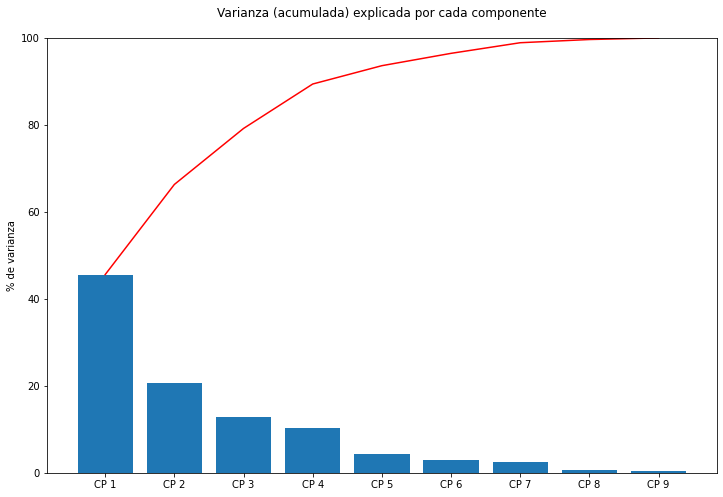

In [ ]:
np.random.seed(5)
# Crear el estimador de Componentes Principales
pca = PCA()

# Introducimos nuestros datos en el estimador
modelo_pca = pca.fit(datos_std)

# Porcentaje de la varianza total de los datos explicada por cada factor o componente principal
varianzas_ratio_comp = modelo_pca.explained_variance_ratio_ * 100

# Y los porcentajes acumulados de varianza explicada
acumulado = varianzas_ratio_comp.cumsum()

# Número de componentes principales o factores que pueden ser extraídos
n_comp = modelo_pca.n_components_

# creamos una lista de componentes
cps = ['CP ' + str(i) for i in range(1, datos.shape[1]+1)]

# Visualizamos los porcentajes de varianza explicados
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.bar(
    x      = cps,
    height = varianzas_ratio_comp
    )
ax.plot(acumulado, c='red')
ax.set_xticks(np.arange(n_comp))
ax.set_ylim(0, 100)
ax.set_title('Varianza (acumulada) explicada por cada componente\n')
ax.set_ylabel('% de varianza');

La diferencia de varianza explicada por CP 3 y CP 4 es muy pequeña y quizás tendría sentido incluir el CP 4. Sin embargo, con un 80% de varianza explicada suele bastar y además mantenernos en un espacio tridimensional nos permite la visualización gráfica.  
Explicar las puntuaciones.

###**Interpretando las componentes extraídas**  
Analizamos las componentes para descubrir qué representan.

Comenzamos por hallar las cargas factoriales $l_hj$, que son las correlaciones entre las variables original $X_j$. y la componente extraída $Z_h$.  
Operando y teniendo en cuenta que con datos estandarizados la varianza de las variables originales es 1, tenemos que: $$l_{hj}=u_{hj}\sqrt{\lambda_{h}}$$ que escrito en notación matricial será $$\textbf{L}=\textbf{U}\sqrt{\boldsymbol\lambda}$$.

$u_{hj}$ es el elemento $j$ del autovector asociado a la componente $h$  
$\lambda_h$ es el autovalor de la componente $h$ y coincide con el valor de la varianza explicada por dicha componente.  
$\textbf{U}$ es la matriz de $p$ columnas (tantas como variables originales) y tantas filas como componentes extraídos (hasta un máximo de $p$).  
$\boldsymbol\lambda$ es una matriz diagonal de los autovalores de la matriz de covarianzas (o correlaciones si los datos son estandarizados)

In [ ]:
cargas = modelo_pca.components_.T * np.sqrt(modelo_pca.explained_variance_)

# añadir un segundo indice con la descripcion de las dimensiones
dims = ['Condiciones materiales de vida',
        'Trabajo',
        'Salud',
        'Educación',
        'Ocio y relaciones sociales',
        'Seguridad física y personal',
        'Gobernanza y derechos básicos',
        'Entorno y medioambiente',
        'Experiencia general de la vida']

cargas_mostrar = pd.DataFrame(np.round(cargas, 2), 
                             columns=['CP ' + str(i) for i in range(1, datos.shape[1]+1)]).\
                              set_index([datos.columns, dims])
cargas_mostrar

CP 1  CP 2  CP 3  CP 4  CP 5  CP 6  \
dim 1 Condiciones materiales de vida -0.96  0.12 -0.01 -0.27 -0.01  0.06   
dim 2 Trabajo                        -0.89 -0.25  0.26 -0.03  0.20 -0.01   
dim 3 Salud                          -0.71 -0.49  0.33  0.24 -0.17  0.24   
dim 4 Educación                      -0.83  0.03  0.45  0.05  0.05 -0.35   
dim 5 Ocio y relaciones sociales     -0.47 -0.23 -0.49  0.69  0.24  0.03   
dim 6 Seguridad física y personal    -0.62  0.44 -0.62 -0.17  0.07 -0.10   
dim 7 Gobernanza y derechos básicos   0.13 -0.79 -0.13 -0.52  0.32  0.06   
dim 8 Entorno y medioambiente        -0.90  0.13 -0.28 -0.24 -0.25  0.12   
dim 9 Experiencia general de la vida  0.05 -0.88 -0.35  0.01 -0.32 -0.23   

                                      CP 7  CP 8  CP 9  
dim 1 Condiciones materiales de vida  0.17 -0.04 -0.14  
dim 2 Trabajo                         0.27  0.10  0.08  
dim 3 Salud                          -0.22  0.09 -0.02  
dim 4 Educación                      -0.17 -0.07 -0.00  
dim 5 Ocio y relaciones sociales      0.02 -0.08 -0.01  
dim 6 Seguridad física y personal    -0.16  0.15 -0.00  
dim 7 Gobernanza y derechos básicos  -0.14 -0.05 -0.00  
dim 8 Entorno y medioambiente        -0.02 -0.13  0.09  
dim 9 Experiencia general de la vida  0.10  0.03 -0.01

En esta tabla podemos observar las correlaciones entre las distintas componentes principales y dimensiones. En su mayoria encontramos una correlación negativa, por lo que las condiciones descritas en esas dimensiones variaran inversamente a como lo hace el CP. Nos quedamos con las 3 primeras CP al ser las más representativas, como hemos visto con la varianza acumulada. Posteriormente analizaremos la carga factorial de cada CP respecto a las distintas dimensiones. 

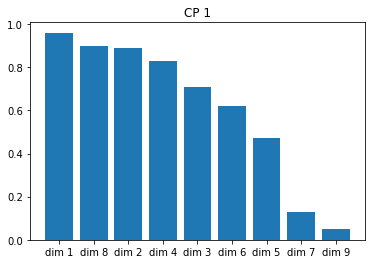

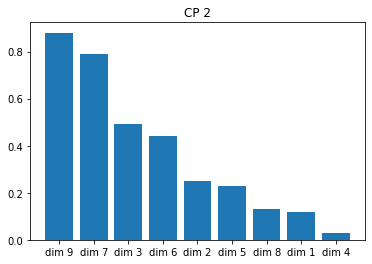

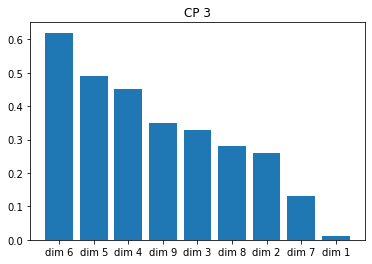

In [ ]:
# eliminamos el indice de descripción para que funciones el loop
cargas_mostrar.reset_index(1, drop=True, inplace=True)

figs={}
axs={}
for cp, cargas in cargas_mostrar.iloc[:, :3].iteritems():
  cargas=cargas.abs().sort_values(ascending=False)
  figs[cp]=plt.figure()
  axs[cp]=figs[cp].add_subplot(111)
  axs[cp].bar(x=cargas.index, height=cargas.values, )
  axs[cp].set_title(cp)
plt.show()

De los gráficos extraemos la siguiente conclusión. La componente 1 está muy correlacionada con las condiciones materiales de vida, el medio ambiente y el trabajo. Además está correlación es negativa, por lo que las comunidades que puntúen alto en CP 1 podremos decir que tendrán bajos niveles de bienestar material, satisfacción con el medio ambiente y sus condiciones de trabajo como sucede en el cluster formado por Andalucía, Murcia, Ceuta y Canarias. 
La segunda componente correlaciona principalmente con las dimensiones de experiencie general con la vida y la gobernanza y derechos básicos. Lo hace también de forma negativa, por lo que podemos decir que una baja puntuación en la componente 2 implicará valores altos en estas dimensiones. Es el caso del cluster de Baleares, Valencia, Melilla y Extremadura. 
Finalmente, la CP 3 correlaciona principal y negativamente con la dimensión de seguridad física y personal. Niveles altos de esta componente indican una bajo sentimiento de seguridad personal, Sería el caso del cluster formado por Madrid, Cataluña y País Vasco. 


---

Para culminar la reducción de la dimensionalidad las coordenadas de las observaciones de nuestro dataset pueden expresarse en el nuevo sistema de coordenadas: las tres componentes extraídas.

In [ ]:
# datos transformados a los nuevos factores. 
scores = modelo_pca.transform(datos_std) 
# el resultado es una lista de 19 listas, cada lista contiene 9 elementos

# los datos listos para usarse en el análisis cluster son:
df_cluster = pd.DataFrame(scores, 
                          columns=['CP ' + str(i) for i in range(1, datos.shape[1]+1)],
                          index=datos.index).\
                          iloc[:,:3]
                          
# Una muestra de estas puntuaciones:
df_cluster

CP 1      CP 2      CP 3
CCAA                                                    
Andalucía                   2.372762  1.560270  0.138573
Aragón                     -2.165019 -0.612542 -1.051451
Principado de Asturias     -0.780633  0.956528 -0.514056
Illes Balears              -0.752510 -2.653002 -1.092734
Canarias                    2.890152  0.171180  0.239177
Cantabria                  -1.976461  0.721473 -1.425683
Castilla y León            -1.309892  2.526980 -0.442005
Castilla-La Mancha          0.190748  0.929896 -0.396324
Cataluña/Catalunya         -0.138313 -0.983860  1.514755
Comunitat Valenciana        0.464770 -1.093051 -0.555539
Extremadura                 1.037314  0.357917 -1.637731
Galicia                    -0.085527  2.708085  0.475216
Comunidad de Madrid        -0.987149 -1.237050  2.326600
Región de Murcia            2.409497  0.150211  0.445728
Comunidad Foral de Navarra -3.180925 -0.976106  0.295665
País Vasco/Euskadi         -2.568041  0.739140  2.265874
La Rioja                   -1.898472 -0.873243 -0.678305
Ciudad Autónoma de Ceuta    4.471587 -0.660823  0.354994
Ciudad Autónoma de Melilla  2.006112 -1.732004 -0.262755

##**Agrupamiento en clusters**

###**Método del codo**

Una vez reducidos los datos podemos pasar al Análisis de Conglomerados.

Utilizaremos el método K-means, que agrupa los elementos o variables analizadas en un número de clusters ya predeterminado. Para ver el número de cluster adecuado, aplicaremos el **método Elbow** o método del codo, en el cual medimos la distancia promedia de todos los puntos del cluster y su centroide, a través de la suma de sus cuadrados, con el objetivo de minimizar la varianza intra-cluster y maximizar de la varianza inter-cluster. 

Para calcularlo matemáticamente, nos situamos en el gráfico, donde tenemos en el eje x el número de cluster utilizados y en el eje y la suma de los cuadrados intra-cluster (dentro del cluster). Trazamos una línea entre los puntos calculados entre el primer y el último cluster, ese punto óptimo, en el que hay una mayor homogeneidad dentro del cluster y una mayor diferencia entre los cluster, es el punto más distante con la línea trazada. Dado que tenemos 20 variables, creemos conveniente encoger que los cluster se sitúen entre 2 y 10, ya que el punto más alejado se encontrará ahí, en 20 la distancia es 0. 

Para calcular la distancia de cada punto a la línea trazada se utiliza la siguiente fórmula:  

$$D[(P_0,P_1),(x,y)] = \frac{|(y_1-y_0)x-(x_1-x_0)y+x_1y_o-y_1x_0|}{\sqrt{(y_1-y_0)^2+(x_1-x_0)^2}}$$  

Para calcularlo en nuestro código, utilizaremos nuestra lista inercia[ ],que contiene la suma de cuadrados dentro de los cluster y nos delvolverá el número optimo de cluster.


El número óptimo de clusters es:  5 



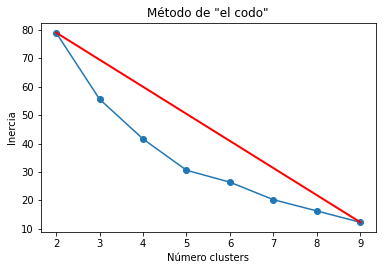

In [ ]:
# La inercia hace referencia a la varianza interna de los clusters
rango_clusters = range(2, 10)
inercia = []

for i in rango_clusters:
    modelo_cluster = KMeans(
                        n_clusters   = i, 
                        n_init       = 20, 
                        random_state = 50
                     )
    modelo_cluster.fit(df_cluster)
    inercia.append(modelo_cluster.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(rango_clusters, inercia, marker='o')
ax.set_title('Método de "el codo"')
ax.set_xlabel('Número clusters')
ax.set_ylabel('Inercia');

# Matemáticamente
# Hallar la distancia entre un punto (x, y) de una serie y la linea que une los extremos 
# de dicha serie P_0 (x_0, y_0) y P_1(x_1, y_1)


# 1- determinamos los puntos P_0 y P_1
x0, y0 = 2, inercia[0]
x1, y1 = 9, inercia[len(inercia)-1]

# 2-dibujamos la línea que une P-0 y P_1
ax.plot([x0, x1], [y0, y1], color='red', linewidth=2)

# 3-determinamos las distancias desde cada punto x, y a la recta P_0-P_1
# los puntos x, y se corresponden con la inercia para cada valor de n clusters
distancias = []
for i in range(len(inercia)):
  x = i+2
  y = inercia[i]
  numerador = abs((y1-y0)*x - (x1-x0)*y + x1*y0 - y1*x0)
  denominador = np.sqrt((y1 - y0)**2 + (x1 - x0)**2)
  distancias.append(numerador/denominador)
print('\nEl número óptimo de clusters es: ', distancias.index(max(distancias)) + 2, '\n')

###**Representación gráfica**  
Vamos a representar un gráfico tridimensional, donde cada eje representará a una CP.Además, las CCAA estarán agrupadas en 5 clusters, a raíz de las puntuaciones de cada una de ellas en las distintas CP. Por último, representaremos las cargas factoriales de cada dimensión respecto a cada CP. 

In [ ]:
# eliminamos la salida gráfica de esta celda de codigo
%%capture

# Crear estimador de K medias. alimentarlo con datos transformados
modelo_cluster = KMeans(n_clusters=5)
modelo_cluster.fit(df_cluster)

# Coordenadas de los centroides en los 3 ejes (3 componentes principales)
C = modelo_cluster.cluster_centers_

# lista de a qué cluster pertenece cada observación (0, 1, 2, 3, 4)
cluster_obs = modelo_cluster.predict(df_cluster)

# asignar un color a cada observación según cluster
colores = ['red','green','blue','brown', 'orange']
color_obs = []
for observacion in cluster_obs:
  color_obs.append(colores[observacion])

# lista de CCAA para uso como auxiliar
#ccaa = df_cluster.index
ccaa = ['AND', 'ARA', 'AST', 'BAL', 'CANR', 'CANT', 'CyL', 'CLM', 'CAT', 
        'VAL', 'EXT', 'GAL', 'MAD', 'MUR', 'NAV', 'PV', 'RIO', 'CEU', 'MEL']


# Crear elemento de visualización
fig = plt.figure()
ax = Axes3D(fig)
ax.set_title('IMCV')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

# plotear y anotar punto a punto
for i in range(len(df_cluster)): # plot each point + it's index as text above
  x = df_cluster.iloc[i,0]
  y = df_cluster.iloc[i,1]
  z = df_cluster.iloc[i,2]
  label = ccaa[i]
  ax.scatter(x, y, z, color=color_obs[i])
  ax.text(x, y , z, 
          '%s' % (label), 
          size=10, 
          zorder=1, 
          color=color_obs[i], 
          alpha=.75)

# añadir los centroides al plot
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=100)

# cargas devuelve un array con 9 listas (una por cada variable original) y cada
# lista contiene 9 elementos (uno por cada componente principal)
cargas = modelo_pca.components_.T * np.sqrt(modelo_pca.explained_variance_)

for i, feature in enumerate(datos.columns):
  x_carga=cargas[i, 0]
  y_carga=cargas[i, 1]
  z_carga=cargas[i, 2]
  ax.plot([0, x_carga], [0, y_carga], [0, z_carga])
  ax.text(x_carga, y_carga, z_carga, '%s' % (feature))

# rotacion
def rotar(angulo):
    ax.view_init(azim=angulo)

rotacion= animation.FuncAnimation(fig, rotar, frames=np.arange(0,360,2),interval=100)

rotacion.save('rotation.gif', dpi=80, writer='imagemagick')


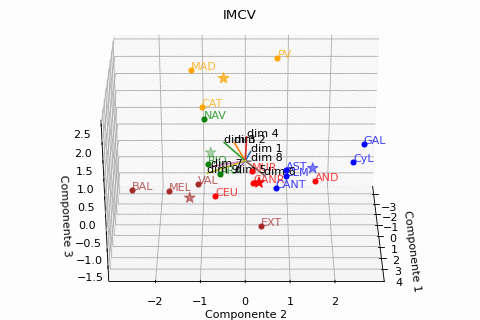

In [ ]:
# Abrir gráfico animado
Image(open('/content/rotation.gif', 'rb').read())



---




Entendiendo el centroide como el punto medio de las distintas CCAA dentro del cluster. En esta tabla observamos como, al igual que ocurre con las CCAA, cada centroide está más representado por un CP que por otro, donde los datos cercanos a 0 muestran una representación media y un valor por encima de 1 o -1 representa mayor o menor representatividad. Por ejemplo, el cluster 3 tiene una alta representatividad del CP 3, pero una baja representatividad del CP 1.

##**Visualización de los resultados**  
El resultado final de nuestros análisis puede verse reflejado en el mapa autonómico donde cada color representará un cluster diferente.

In [ ]:
# importamos datos geográficos
can_file = r'https://github.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE/blob/master/mapas/canarias.zip?raw=true'
pen_file = r'https://github.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE/blob/master/mapas/peninsula.zip?raw=true'
canarias =gpd.read_file(can_file)
peninsula_baleares = gpd.read_file(pen_file)

# unimos los datos cartograficos
mapa = gpd.GeoDataFrame(pd.concat([peninsula_baleares, canarias]))#.to_crs("EPSG:3395")

# creamos columna indicando a qué cluster pertenece cada CCAA y renombramos los Cluster
df_cluster['Cluster'] = cluster_obs
df_cluster['Cluster'] = df_cluster['Cluster'].map({0:'Cluster 1',
                                                   1:'Cluster 2',
                                                   2:'Cluster 3',
                                                   3:'Cluster 4',
                                                   4:'Cluster 5'})

# Añadimos los datos de los clusters al GeoDataFrame
# Nos gustaría crear en un futuro un mapa interactivo en el que se mostraran las 
# puntuaciones en CP 1, CP 2 y CP 3. 
tabla_mapa = pd.merge(mapa, 
                      df_cluster, 
                      left_on='NAMEUNIT', 
                      right_index=True)[["NAMEUNIT", 
                                         #"CP 1", 
                                         #"CP 2", 
                                         #"CP 3", 
                                         "Cluster", 
                                         "geometry"]]
tabla_mapa


NAMEUNIT    Cluster  \
1   Ciudad Autónoma de Melilla  Cluster 4   
2     Ciudad Autónoma de Ceuta  Cluster 1   
3                     La Rioja  Cluster 2   
4           País Vasco/Euskadi  Cluster 5   
5   Comunidad Foral de Navarra  Cluster 2   
6             Región de Murcia  Cluster 1   
7          Comunidad de Madrid  Cluster 5   
8                      Galicia  Cluster 3   
9                  Extremadura  Cluster 4   
10        Comunitat Valenciana  Cluster 4   
11          Cataluña/Catalunya  Cluster 5   
12          Castilla-La Mancha  Cluster 3   
13             Castilla y León  Cluster 3   
14                   Cantabria  Cluster 3   
15               Illes Balears  Cluster 4   
16      Principado de Asturias  Cluster 3   
17                      Aragón  Cluster 2   
18                   Andalucía  Cluster 1   
0                     Canarias  Cluster 1   

                                             geometry  
1   POLYGON ((-2.95264 35.32030, -2.95258 35.32015...  
2   POLYGON ((-5.38206 35.91240, -5.38192 35.91248...  
3   POLYGON ((-2.75758 42.03262, -2.75738 42.03310...  
4   MULTIPOLYGON (((-2.68167 43.42275, -2.68192 43...  
5   MULTIPOLYGON (((-1.18282 42.42390, -1.18283 42...  
6   MULTIPOLYGON (((-1.62325 37.37813, -1.62332 37...  
7   MULTIPOLYGON (((-4.31951 40.64766, -4.32222 40...  
8   MULTIPOLYGON (((-8.88480 41.88241, -8.88494 41...  
9   POLYGON ((-6.92477 38.20528, -6.92571 38.20454...  
10  MULTIPOLYGON (((-0.75350 37.87162, -0.75355 37...  
11  MULTIPOLYGON (((0.64888 40.57847, 0.64831 40.5...  
12  MULTIPOLYGON (((-3.38214 40.63047, -3.38194 40...  
13  MULTIPOLYGON (((-4.10157 42.79373, -4.10439 42...  
14  MULTIPOLYGON (((-3.30453 43.25826, -3.29325 43...  
15  MULTIPOLYGON (((1.47907 38.71071, 1.47900 38.7...  
16  MULTIPOLYGON (((-4.55610 43.39481, -4.55636 43...  
17  POLYGON ((0.14136 40.71821, 0.12382 40.72081, ...  
18  MULTIPOLYGON (((-3.03529 35.93767, -3.03539 35...  
0   MULTIPOLYGON (((-17.96450 27.68740, -17.96445 ...

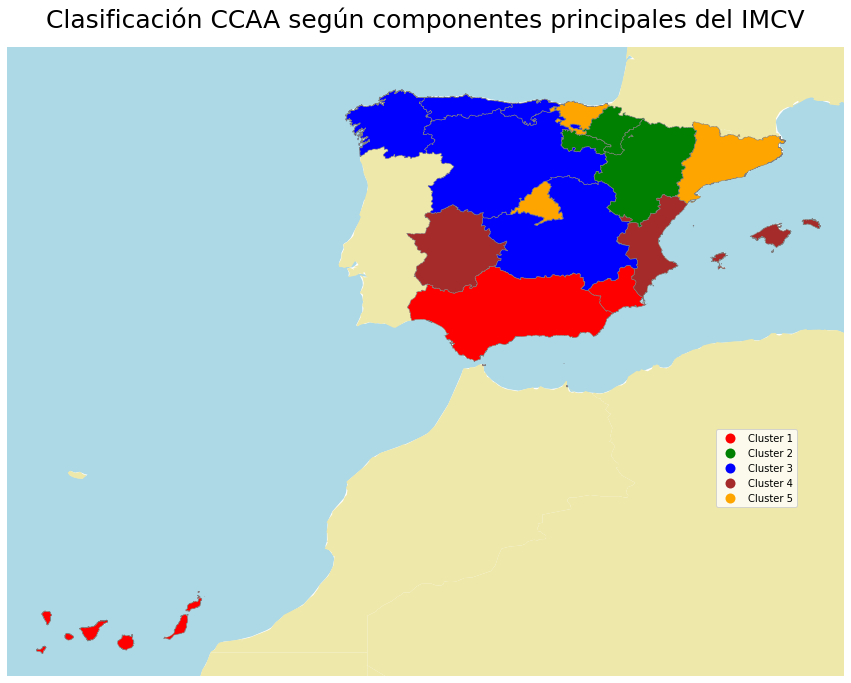

In [ ]:
# Creamos la figura y establecemos su tamaño:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
 
# Establecemos los límites de longitud y latitud a cartografiar.
ax.axis([-19, 5, 27, 45]) 
 
# Título
ax.set_title('Clasificación CCAA según componentes principales del IMCV', 
             pad = 20, #Eleva el título, separándolo del contorno de la figura
             fontdict={'fontsize':25})

# Eliminar ejes
ax.set_axis_off()

# creamos un listado de colores coincidente con los asignados a los clusters.
# De esta forma los colores en el mapa coincidirán con los utilizados en el gráfico 3D
cmap = ListedColormap(colores)

#Dibujamos nuestro mapa de CCAA:
tabla_mapa.plot(ax=ax,
                column='Cluster',
                cmap=cmap,
                categorical=True,
                edgecolor="grey",
                linewidth=0.5,
                legend=True,
                zorder=5);
# Ajustamos la posición de la leyenda
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.75, 0.2, 0.2, 0.2))


# Añadimos capa de mares al mapa
oceanos_file = r'https://github.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE/blob/master/mapas/oceanos.zip?raw=true'
mapa_oceanos = gpd.read_file(oceanos_file)#.to_crs("EPSG:3395")
mapa_oceanos.plot(ax=ax,
                 color="lightblue",
                 zorder=0);

# Añadimos capa de países
paises_file = r'https://github.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE/blob/master/mapas/paises.zip?raw=true'
mapa_paises = gpd.read_file(paises_file)#.to_crs("EPSG:3395")
mapa_paises.plot(ax=ax,
                 color="palegoldenrod",
                 linewidth=0,
                 zorder=2);


A modo de resumen presentamos las puntuaciones de los centroides de cada cluster

In [ ]:
centroides = pd.DataFrame(C, columns=['CP 1', 'CP 2', 'CP 3'], index=range(5))
centroides.index.name = "Cluster"
centroides.index += 1
centroides

CP 1      CP 2      CP 3
Cluster                              
1        3.035999  0.305210  0.294618
2       -2.414805 -0.820631 -0.478030
3       -0.792353  1.568593 -0.460570
4        0.688921 -1.280035 -0.887190
5       -1.231168 -0.493923  2.035743

###**Conclusiones**
La posición de los centroides nos muestra el promedio de las puntuaciones de las distintas variables que componen el cluster y la representatividad respecto a cada CP. Por ejemplo, en el cluster 1 tenemos que el centroide muestra valores muy representados en el CP 1, al contrario ocurre con el cluster 2. Extrapolando estos resultados, junto a las diferentes CCAA que componen cada cluster y a las correlaciones de los CP y las distintas dimensiones, podemos extraer algunas características de los distintos clusters. Por ejemplo: 
- El cluster 5, compuesto por Madrid, Cataluña y País Vasco, presenta buenos niveles de eduación, condiciones de vida o trabajo, dada la posición del centroide y la correlación negativa del CP 1 y la positiva del CP 3 con esas dimensiones. 
- En el cluster 4, compuesto por la Comunidad Valenciana, Extremadura, Melilla y las Islas Baleares, presentan buenos índices de gobernanza y derechos básicos. 
- El cluster 3, entre las que se encuentran Castilla-La Mancha, Castilla y León, Galicia, Asturias y Cantabria, presentan bajos índices de experiencia general de la vida y gobernanza y derechos básicos. 
- El cluster 2, compuesto por Aragón, Navarra y La Rioja, presentan buenos índices de trabajo, educación, condiciones de vida y entorno y medio ambiente. 
- Por último, el cluster 1, compuesto por Andalucia, Murcia, Ceuta y Canarias, presenta bajos índices de condiciones de vida, trabajo, educación o entorno y medio ambiente.